In [11]:
# CREATED: 9-JUN-2023
# LAST EDIT: 12-JUN-2023
# AUTHOR: DUANE RINEHART, MBA (drinehart@ucsd.edu)

#PROOF OF CONCEPT FOR DASK IMAGE PROCESSING (INSTEAD OF IMAGE TILING)
#ref: https://examples.dask.org/applications/image-processing.html
#ref: https://saturncloud.io/blog/a-data-scientist-s-guide-to-lazy-evaluation-with-dask/

import dask
from dask import delayed
import dask.array as da
from dask.distributed import Client, LocalCluster
import os, time
from pathlib import Path
import imageio.v2 as imageio
import glob
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

img_src_folder = "input"
cwd = os.getcwd()
input_path = Path(cwd, img_src_folder)
print(f'SRC IMAGE PATH: {input_path}')
max_n_workers = int(0.9 * mp.cpu_count())
max_client_ram = "32GB"
scratch_dir = "d:/temp"

start = time.time()
base_path_with_pattern = str(input_path) + '/*.tif'
image_paths = [files for files in glob.glob(base_path_with_pattern, recursive=False)]


def load_image(path):
    return imageio.imread(path)


def show_image(img_array):
    plt.imshow(img_array)
    plt.show()

#SETUP DASK CLUSTER (AUTOCLOSE)
with LocalCluster(
    n_workers=max_n_workers,
    processes=True,
    threads_per_worker=1,
    memory_limit=max_client_ram,
    local_directory=scratch_dir) as cluster, Client(cluster) as client:

    # Create delayed tasks for loading the images
    delayed_tasks = [delayed(load_image)(path) for path in image_paths]
    shape = dask.compute(delayed_tasks[0].shape) #GET SHAPE WITHOUT COMPUTING

    x_dim = shape[0][0]
    y_dim = shape[0][1]

    # Create a Dask array from the delayed tasks (NOTE: DELAYED)
    image_stack = [da.from_delayed(v, shape=(x_dim, y_dim), dtype='uint16') for v in delayed_tasks]


end = time.time()
print(f'TOTAL IMAGES: {len(delayed_tasks)}')
print(f'INDIVIDUAL IMAGE SHAPE: {x_dim, y_dim}')
print("Operation time: ", (end - start), "sec")

SRC IMAGE PATH: D:\dev\image_tiling\input


D:\venv\cell_extractor\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64843 instead
  warnings.warn(


TOTAL IMAGES: 10
INDIVIDUAL IMAGE SHAPE: (33500, 55500)
Operation time:  24.981878995895386 sec


In [103]:
correspondence = zip(image_paths, delayed_tasks)
for cnt, tpl_item in enumerate(correspondence):
    print(cnt, tpl_item)

0 ('D:\\dev\\image_tiling\\input\\000.tif', Delayed('load_image-2cf1f12d-a47f-4c3c-8ec7-15b3aaf41a59'))
1 ('D:\\dev\\image_tiling\\input\\001.tif', Delayed('load_image-bab4fdeb-c580-4449-9f15-326404033fb0'))
2 ('D:\\dev\\image_tiling\\input\\002.tif', Delayed('load_image-f03fcceb-ba2c-4aed-a28e-25a7cdd873b3'))
3 ('D:\\dev\\image_tiling\\input\\003.tif', Delayed('load_image-78ebfb3e-c258-47b1-bd52-01f17035a083'))
4 ('D:\\dev\\image_tiling\\input\\004.tif', Delayed('load_image-434e6c5d-98e8-47d2-ac34-e468fe0e66ee'))
5 ('D:\\dev\\image_tiling\\input\\005.tif', Delayed('load_image-7a19500a-720a-48c8-aced-0ba912e1357e'))
6 ('D:\\dev\\image_tiling\\input\\006.tif', Delayed('load_image-3a45ce9f-f29b-4d6b-af7a-d33c9c763882'))
7 ('D:\\dev\\image_tiling\\input\\007.tif', Delayed('load_image-eb8e310d-b714-487c-b931-d5338abec93d'))
8 ('D:\\dev\\image_tiling\\input\\008.tif', Delayed('load_image-1fbd482a-55f0-4e40-9b42-823a93af2643'))
9 ('D:\\dev\\image_tiling\\input\\009.tif', Delayed('load_image-

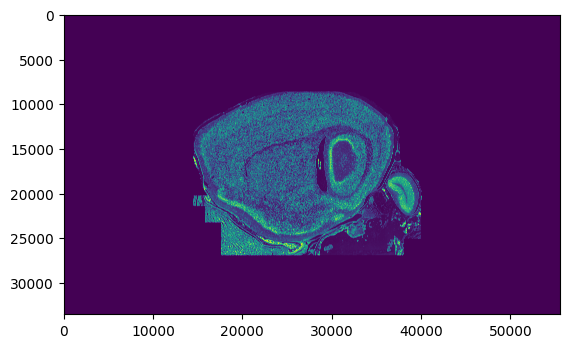

(33500, 55500)

In [4]:
data = dask.compute(image_stack[0])[0] #FULL IMAGE
show_image(data)
data.shape

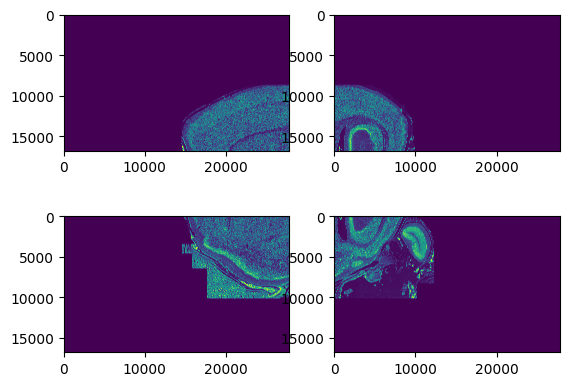

In [94]:
#SPLIT IN 4 (NOTE: ROWS SLICE IS FIRST)

image_roi_1 = data[0:16750, 0:27750] #UPPER LEFT
#show_image(image_roi_1)

image_roi_2 = data[0:16750, 27750:55500] #UPPER RIGHT
#show_image(image_roi_2)

image_roi_3 = data[16750:33500, 0:27750] #LOWER LEFT
#show_image(image_roi_3)

image_roi_4 = data[16750:33500, 27750:55500] #LOWER RIGHT
#show_image(image_roi_4)

fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(image_roi_1)
ax[0,1].imshow(image_roi_2)
ax[1,0].imshow(image_roi_3)
ax[1,1].imshow(image_roi_4)
plt.show()

D:\venv\cell_extractor\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65038 instead
  warnings.warn(


TILE WINDOW DIMENSIONS: (16750, 27750)
0:16750, 0:27750
0:16750, 27750:55500
16750:33500, 0:27750
16750:33500, 27750:55500


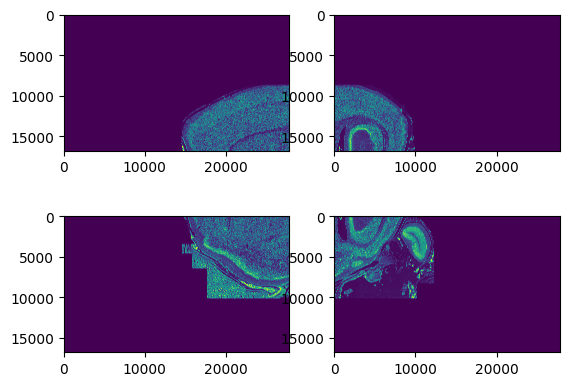

Operation time:  40.36067247390747 sec


In [12]:
#MOVING WINDOW

start = time.time()
data = dask.compute(image_stack[0])[0] #FULL IMAGE

#SETUP DASK CLUSTER (AUTOCLOSE)
with LocalCluster(
    n_workers=max_n_workers,
    processes=True,
    threads_per_worker=1,
    memory_limit=max_client_ram,
    local_directory=scratch_dir) as cluster, Client(cluster) as client:


    #TUPLE SRC SHAPE EX. (33500, 55500)
    #SPLIT INTO TILES (ROWS x COLS)
    split_rows = 2
    split_cols = 2

    x_window = int(data.shape[0]/split_rows)
    y_window = int(data.shape[1]/split_cols)

    print(f'TILE WINDOW DIMENSIONS: {x_window, y_window}')


    fig, ax = plt.subplots(nrows=split_rows, ncols=split_cols)

    for row in range(split_rows):
        for col in range(split_cols):
            print(f'{row*x_window}:{x_window*(row+1)}, {col*y_window}:{y_window*(col+1)}')

            image_roi = data[(row*x_window):x_window*(row+1), (col*y_window):y_window*(col+1)]
            ax[row, col].imshow(image_roi)

plt.show()
end = time.time()
print("Operation time: ", (end - start), "sec")

In [ ]:
#RECONSTRUCTING TILED IMAGES INTO SINGLE, LARGE IMAGE
#ref: https://github.com/VolkerH/DaskFusion/blob/main/DaskFusion_Example.ipynb